In [1]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import json
from tqdm.auto import tqdm
from itertools import islice
from datetime import datetime
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from transformers import BertForSequenceClassification, BertTokenizerFast

## Data Dependencies

```
../data/di-morphosyntax.csv 0f1c87
```

In [3]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/di-morphosyntax.csv"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/di-morphosyntax.csv 0f1c87


## Loading Data

In [4]:
data = pd.read_csv("../data/di-morphosyntax.csv", index_col=0)
pd.value_counts(data.MorphoSyntax), pd.value_counts(data.MorphoSyntax).sum()
mr_data = data.dropna(axis=0, subset=["MorphoSyntax"])
print(mr_data.shape)
mr_data.head()

(1676, 8)


,token,source,ASBC,Apple (2006-2016),China (2015-2016),Dcard (2019-2020),PTT (2004-2019),MorphoSyntax
4073,丟來,Corpus,1.0,5.0,5.0,1.0,0.0,VR
4074,丟光,Corpus,2.0,16.0,6.0,1.0,0.0,VR
4077,丟出,Corpus,9.0,190.0,56.0,16.0,0.0,VR
4079,丟到,Corpus,53.0,265.0,75.0,48.0,0.0,VR
4087,丟命,"MOE, Corpus",1.0,5.0,2.0,0.0,0.0,VO


In [5]:
mr_data.MorphoSyntax.value_counts()

VR    879
AV    340
VV    244
VO    213
Name: MorphoSyntax, dtype: int64

## Prepare dataset

In [6]:
class MrDataset(Dataset):
    def __init__(self, mrdata):
        self.data = [(x.token, x.MorphoSyntax) 
                     for _, x in mrdata.iterrows()]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [7]:
mr_data_shuffled = mr_data.sample(frac=1, random_state=1234)
n_split = int(mr_data.shape[0]*.8)
mr_data_train = mr_data_shuffled[:n_split]
mr_data_test = mr_data_shuffled[n_split:]
train_ds = MrDataset(mr_data_train)
test_ds = MrDataset(mr_data_test)
mr_vocab = LabelEncoder()
train_classes = mr_vocab.fit_transform([x[1] for x in train_ds])

In [8]:
train_words = mr_data_train.token.tolist()
test_words = mr_data_test.token.tolist()
# ensure no leakage
assert all(x not in test_words for x in train_words)

In [9]:
with open("../data/10.02-word-split.json", "w", encoding="UTF-8", newline="\n") as fout:
    json.dump({"train": train_words, "test": test_words}, fout)

## Prepare training

In [10]:
mr_weights = compute_class_weight('balanced', classes=np.unique(train_classes), y=train_classes)
mr_weights

array([1.21376812, 1.97058824, 0.47788873, 1.7357513 ])

In [11]:
BASE_MODEL = "bert-base-chinese"

In [12]:
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL)

In [13]:
@dataclass
class MrCollator:
    tokenizer: "BertTokenizerFast"
    mr_vocab: "LabelEncoder"
    def __call__(self, batch):
        toks = self.tokenizer([x[0] for x in batch], return_tensors="pt")
        mrs = self.mr_vocab.transform([x[1] for x in batch])
        toks["labels"] = torch.tensor(mrs)
        return toks

In [14]:
collator = MrCollator(tokenizer, mr_vocab)

## Train Loops

In [15]:
## to get rid of tokenizer fork warning
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [16]:
torch.manual_seed(13245)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_acc_metric = torchmetrics.Accuracy().to(device)
eval_acc_metric = torchmetrics.Accuracy().to(device)
train_loss_metric = torchmetrics.MeanMetric().to(device)
eval_loss_metric = torchmetrics.MeanMetric().to(device)
loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(mr_weights, dtype=torch.float32).to(device))
train_loader = DataLoader(train_ds, shuffle=True, batch_size=32, collate_fn=collator)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=32, collate_fn=collator)

In [17]:
model = BertForSequenceClassification.from_pretrained(
            BASE_MODEL, 
            num_labels=len(mr_vocab.classes_),
            id2label={i:x for i,x in enumerate(mr_vocab.classes_)},
            label2id={i:x for i,x in enumerate(mr_vocab.classes_)},)
model = model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [19]:

n_epoch = 30
train_accs = []
eval_accs = []
eval_losses = []
train_losses = []
best_eval_acc = 0
early_stop_patience = 10

n_batch = len(train_loader)
n_iter = n_batch * n_epoch
pbar = tqdm(total=n_iter)

for _ in range(n_epoch):        
    model.train()
    for batch_x in train_loader:
        batch_x.to(device)
        pbar.update(1)
        optimizer.zero_grad()
        out = model(**batch_x)        
        preds = out.logits.argmax(-1)        
        labels = batch_x["labels"]
        loss = loss_fct(out.logits.view(-1, model.num_labels), labels.view(-1))        
        loss.backward()
        optimizer.step()
        train_acc_metric(preds, labels)        
        train_loss_metric.update(out.loss.item())    
        
    ## Eval loop
    model.eval()    
    for batch_x in test_loader:
        with torch.no_grad():
            batch_x.to(device)
            out = model(**batch_x)
            preds = out.logits.argmax(-1)
            eval_acc_metric(preds, batch_x["labels"])
            eval_loss_metric.update(out.loss.item())        
    
    # Metrics
    train_acc = train_acc_metric.compute().item()
    eval_acc = eval_acc_metric.compute().item()
    train_loss = train_loss_metric.compute().item()
    eval_loss = eval_loss_metric.compute().item()
    # print("Train accuracy: ", train_acc)
    # print("Eval accuracy: ", eval_acc)
    # print("Eval loss: ", eval_loss)
    train_acc_metric.reset()
    eval_acc_metric.reset()
    eval_loss_metric.reset()
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    train_accs.append(train_acc)
    eval_accs.append(eval_acc)
    
pbar.close()

  0%|          | 0/1260 [00:00<?, ?it/s]

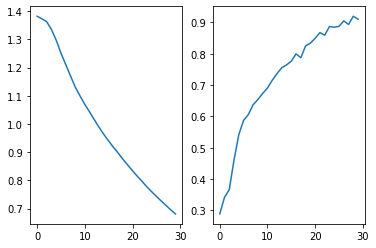

In [20]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.subplot(1, 2, 2)
plt.plot(train_accs)


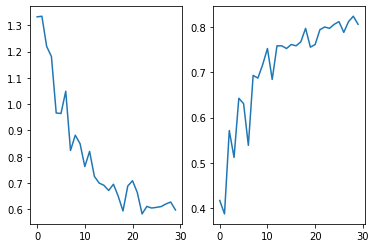

In [21]:
plt.subplot(1, 2, 1)
plt.plot(eval_losses)
plt.subplot(1, 2, 2)
plt.plot(eval_accs)


## Evaluation

In [22]:
model.eval()    
all_preds = []
all_labels = sum((x["labels"].tolist() for x in test_loader), [])
for batch_x in test_loader:
    with torch.no_grad():
        batch_x.to(device)
        out = model(**batch_x)
        preds = out.logits.argmax(-1)
        all_preds.extend(preds.cpu().tolist())
        

(array([0, 1, 2, 3]),
 [Text(0, 0, 'AV'), Text(0, 1, 'VO'), Text(0, 2, 'VR'), Text(0, 3, 'VV')])

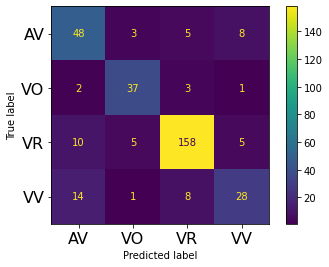

In [23]:
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=mr_vocab.classes_)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [24]:
print(classification_report(all_labels, all_preds, target_names=mr_vocab.classes_))

              precision    recall  f1-score   support

          AV       0.65      0.75      0.70        64
          VO       0.80      0.86      0.83        43
          VR       0.91      0.89      0.90       178
          VV       0.67      0.55      0.60        51

    accuracy                           0.81       336
   macro avg       0.76      0.76      0.76       336
weighted avg       0.81      0.81      0.81       336



## Save model

In [25]:
timestamp = datetime.now().strftime("%y%m%d-%H%M")
out_model_dir = f"../data/models/morphen-alpha-{timestamp}"
model.save_pretrained(out_model_dir)

## Output hash

```
../data/models/morphen-alpha-220802-0840/pytorch_model.bin 0bcf54
../data/10.02-word-split.json 7ac81e
```

In [26]:
from hashlib import sha1
from pathlib import Path
paths = [Path(out_model_dir,"pytorch_model.bin"),
         "../data/10.02-word-split.json"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/models/morphen-alpha-220802-0840/pytorch_model.bin 0bcf54
../data/10.02-word-split.json 7ac81e
